# Feature Analysis

**RankEval** provides feature analysis tools that allow to estimate the **feature importance** of a trained tree-based ensemble. This analysis can be used for feature selection to improve the estimators’ efficiency on very high-dimensional datasets. The general premise is that features can be either irrelevant or redundant, and thus they can be removed from the dataset without incurring in much loss of information.

A benefit of using gradient boosting algorithms consisting of a number of binary decision trees is that it is relatively straightforward to compute feature importance scores at training time. Indeed, each decision tree is described by multiple nodes, either split or leaf nodes. Every split node is a condition on a single feature, and it is designed to split the dataset into two so that similar response values end up in the same set. Computing feature importance is thus as simple as to sum for each decision tree the amount that each split node (i.e., the feature used by the split node) improves a given performance measure. The performance measure most commonly adopted is the Gini index (purity) used to select the next split nodes at training time.

RankEval implement the calculation of feature importance by *simulating* the traditional training behaviour at scoring time, i.e., with the model already fully trained. To this regard RankEval allows to compute feature importance independently of the framework used to train the model, providing insightful also for frameworks that do not support feature analysis. Moreover, the calculation of feature importance is parametric in the performance measure, allowing for fine-grained and personalized analysis.

In [1]:
# set package autoreload and inline plot

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Import RankEval statistical significance tools

In [2]:
# import libraries
import numpy as np

from rankeval.model import RTEnsemble
from rankeval.dataset import Dataset
from rankeval.analysis.feature import feature_importance
from rankeval.visualization.feature import plot_feature_importance
from rankeval.dataset.datasets_fetcher import load_dataset

## Load Dataset using the `load_dataset` feature

In [3]:
# Dataset container
dataset_container = load_dataset(dataset_name='msn10k', 
                                 fold='1', 
                                 download_if_missing=True, 
                                 force_download=False, 
                                 with_models=False)

Loading files. This may take a few minutes.
done loading dataset!


In [4]:
# Remapping Datasets Names
msn_train = dataset_container.train_dataset
msn_validation = dataset_container.validation_dataset
msn_test = dataset_container.test_dataset

## Train LightGBM model with All Features

Create a metric for computing the performance of the model

In [5]:
from rankeval.metrics import NDCG

ndcg_10 = NDCG(cutoff=10, no_relevant_results=0.5, implementation='exp')

In [7]:
import lightgbm
import os

def lightGBM_algo(trees, leaves, train_dataset, vali_dataset):

    lgbm_train_dataset = lightgbm.Dataset(data=train_dataset.X, label=train_dataset.y, group=train_dataset.get_query_sizes())
    lgbm_vali_dataset = lightgbm.Dataset(data=vali_dataset.X, label=vali_dataset.y, group=vali_dataset.get_query_sizes())
    
    # specify parameters via map    
    params = {
        'boosting_type': 'gbdt',
        'objective': 'lambdarank',
        'max_position': 10,
        'metric': ['ndcg'],
        'ndcg_at': [10],
        'num_leaves': leaves,
        'learning_rate': 0.05,
        'verbose': 1,
        'use_missing': False
    }

    lgbm_model = lightgbm.train(
        params, 
        lgbm_train_dataset, 
        num_boost_round=trees,
        valid_sets=[lgbm_train_dataset, lgbm_vali_dataset],
        valid_names=['train', 'vali'],
        early_stopping_rounds=100,
        verbose_eval=10
    )
    
    filename = 'lgbm.model'
    rankeval_model = None
    try:
        lgbm_model.save_model(filename=filename)
        rankeval_model = RTEnsemble(filename, 
                                    name="LightGBM model", 
                                    format="LightGBM")
    finally:
        os.remove(filename)
    
    return rankeval_model 

Train LightGBM model with all features

In [8]:
msn_lgbm_lmart_1Ktrees_model = lightGBM_algo(trees=1000,
                                             leaves=32,
                                             train_dataset=msn_train,
                                             vali_dataset=msn_validation)

Training until validation scores don't improve for 100 rounds.
[10]	train's ndcg@10: 0.443994	vali's ndcg@10: 0.439618
[20]	train's ndcg@10: 0.450154	vali's ndcg@10: 0.444829
[30]	train's ndcg@10: 0.457878	vali's ndcg@10: 0.452552
[40]	train's ndcg@10: 0.464608	vali's ndcg@10: 0.458952
[50]	train's ndcg@10: 0.468864	vali's ndcg@10: 0.462573
[60]	train's ndcg@10: 0.47328	vali's ndcg@10: 0.46681
[70]	train's ndcg@10: 0.477386	vali's ndcg@10: 0.470652
[80]	train's ndcg@10: 0.481041	vali's ndcg@10: 0.473341
[90]	train's ndcg@10: 0.484615	vali's ndcg@10: 0.47746
[100]	train's ndcg@10: 0.488182	vali's ndcg@10: 0.480406
[110]	train's ndcg@10: 0.491569	vali's ndcg@10: 0.483672
[120]	train's ndcg@10: 0.493777	vali's ndcg@10: 0.485387
[130]	train's ndcg@10: 0.496158	vali's ndcg@10: 0.48678
[140]	train's ndcg@10: 0.498536	vali's ndcg@10: 0.488107
[150]	train's ndcg@10: 0.500441	vali's ndcg@10: 0.489426
[160]	train's ndcg@10: 0.502047	vali's ndcg@10: 0.491318
[170]	train's ndcg@10: 0.503779	vali's

The training of the LightGBM model stopped at 824 trees, given that no further improvements were observed on the validation set in the following 100 iterations.

This model, that uses all the features, has a metric score of:

In [9]:
y_pred_train = msn_lgbm_lmart_1Ktrees_model.score(msn_train)
print "%s on Train: %.3f" % (ndcg_10, ndcg_10.eval(msn_train, y_pred_train)[0])

y_pred_test = msn_lgbm_lmart_1Ktrees_model.score(msn_test)
print "%s on Test: %.3f" % (ndcg_10, ndcg_10.eval(msn_test, y_pred_test)[0])

NDCG@10 on Train: 0.546
NDCG@10 on Test: 0.487


### Compute Feature Analysis

The `feature_importance` analysis is executed on a single dataset and model, using a given metric for computing the performance gain at each split node. By default the analysis uses MSE as performance measure (and only in this case the analysis is very efficient since it is realized using low-level cython code). The function returns a xarray.DataArray with the value of `feature_importance` and `feature_count` (the former summing performance gain related to a given feature, the latter counting the number of times a feature is used in a split node) for each feature.

In [10]:
from rankeval.analysis.feature import feature_importance
from rankeval.metrics import MSE

# Create the metric to use as performance measure
mse = MSE()

feature_analysis = feature_importance(model=msn_lgbm_lmart_1Ktrees_model, 
                                      dataset=msn_train, 
                                      metric=mse)
feature_analysis.T.to_dataframe()

Feature Importance Analysis
feature type                                   
0       importance                     0.000048
        count                         19.000000
1       importance                     0.000306
        count                         59.000000
2       importance                     0.000782
        count                        128.000000
3       importance                     0.000083
        count                         15.000000
4       importance                     0.000027
        count                         29.000000
5       importance                     0.000056
        count                         38.000000
6       importance                     0.000064
        count                         25.000000
7       importance                     0.000240
        count                         86.000000
8       importance                     0.000047
        count                         17.000000
9       importance                     0.000109
        count                         63.000000
10      importance                     0.001707
        count                        593.000000
11      importance                     0.000652
        count                        223.000000
12      importance                     0.001209
        count                        399.000000
13      importance                     0.003241
        count                        634.000000
14      importance                     0.006070
        count                        473.000000
...                                         ...
121     importance                     0.000999
        count                        269.000000
122     importance                     0.000797
        count                        282.000000
123     importance                     0.001218
        count                        192.000000
124     importance                     0.000676
        count                        166.000000
125     importance                     0.002545
        count                        542.000000
126     importance                     0.002899
        count                        874.000000
127     importance                     0.001978
        count                        626.000000
128     importance                     0.005343
        count                        838.000000
129     importance                     0.004238
        count                       1064.000000
130     importance                     0.004147
        count                       1177.000000
131     importance                     0.001462
        count                        522.000000
132     importance                     0.003665
        count                        966.000000
133     importance                     0.021679
        count                        491.000000
134     importance                     0.002691
        count                        575.000000
135     importance                     0.001047
        count                        589.000000

[272 rows x 1 columns]

RankEval provides also a utility for directly plotting the result of the feature analysis in order to have a visual representation of the importance of each feature. The method `plot_feature_importance` takes in input the analysis executed above, as well as the number of top-k features to plot and how to sort the features (by importance gain or by gain). Moreover, it is possible to pass a list of feature names to use in place on feature index in the plot.

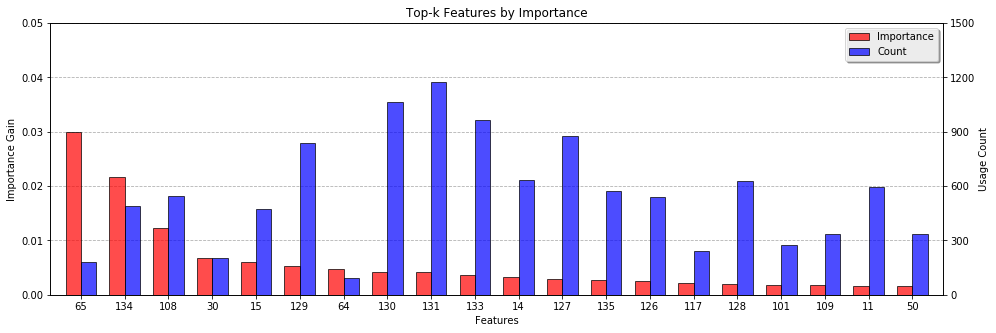

In [11]:
from rankeval.visualization.feature import plot_feature_importance

fig = plot_feature_importance(feature_analysis, max_features=20, sort_by='gain')

## Train LightGBM model by using only Top-20 Features out of 136

In [13]:
sorted_features = np.argsort(feature_analysis.sel(type='importance').values)[::-1]
top_features = sorted_features[:20]

msn_train_filtered = msn_train.subset_features(top_features)
msn_validation_filtered = msn_validation.subset_features(top_features)
msn_test_filtered = msn_test.subset_features(top_features)

msn_lgbm_lmart_1Ktrees_top20f_model = lightGBM_algo(trees=1000,
                                                    leaves=32,
                                                    train_dataset=msn_train_filtered,
                                                    vali_dataset=msn_validation_filtered)

Training until validation scores don't improve for 100 rounds.
[10]	train's ndcg@10: 0.436757	vali's ndcg@10: 0.436719
[20]	train's ndcg@10: 0.444382	vali's ndcg@10: 0.44051
[30]	train's ndcg@10: 0.452432	vali's ndcg@10: 0.446219
[40]	train's ndcg@10: 0.458541	vali's ndcg@10: 0.452828
[50]	train's ndcg@10: 0.463619	vali's ndcg@10: 0.457219
[60]	train's ndcg@10: 0.467108	vali's ndcg@10: 0.459739
[70]	train's ndcg@10: 0.47014	vali's ndcg@10: 0.464062
[80]	train's ndcg@10: 0.47355	vali's ndcg@10: 0.466168
[90]	train's ndcg@10: 0.476205	vali's ndcg@10: 0.468453
[100]	train's ndcg@10: 0.47926	vali's ndcg@10: 0.472125
[110]	train's ndcg@10: 0.482044	vali's ndcg@10: 0.474486
[120]	train's ndcg@10: 0.48459	vali's ndcg@10: 0.476243
[130]	train's ndcg@10: 0.487273	vali's ndcg@10: 0.479102
[140]	train's ndcg@10: 0.489051	vali's ndcg@10: 0.48025
[150]	train's ndcg@10: 0.490879	vali's ndcg@10: 0.482204
[160]	train's ndcg@10: 0.492811	vali's ndcg@10: 0.483461
[170]	train's ndcg@10: 0.493908	vali's n

The training of the LightGBM model using only 20 features stopped at 797 trees, given that no further improvements were observed on the validation set in the following 100 iterations.

THe performance of this model is:

In [14]:
y_pred_train = msn_lgbm_lmart_1Ktrees_top20f_model.score(msn_train_filtered)
print "%s on Train: %.3f" % (ndcg_10, ndcg_10.eval(msn_train_filtered, y_pred_train)[0])

y_pred_test = msn_lgbm_lmart_1Ktrees_top20f_model.score(msn_test_filtered)
print "%s on Test: %.3f" % (ndcg_10, ndcg_10.eval(msn_test_filtered, y_pred_test)[0])

NDCG@10 on Train: 0.526
NDCG@10 on Test: 0.477


Compared to the performance of the model using all features (train: 0.546, test: 0.487) it performs slightly worse but using only 15% of the features.